# <font color='blue'>TCC BIG DATA E CIÊNCIA DE DADOS - PUC MINAS</font>
# <font color='gray'>Análise preditiva de série temporal de vendas do tesouro nacional e comparação com arrecadação federal e PIB nacional</font>


### DADOS ABERTOS DA ARRECADAÇÃO DISPONÍVEL EM:
https://www.gov.br/receitafederal/pt-br/acesso-a-informacao/dados-abertos/receitadata/arrecadacao/analise-gerencial-da-arrecadacao-angela-1/angela-arrecadacao-por-mes-cnae-e-tributo.xlsx/view e

### DADOS ABERTOS DO TESOURO DIRETO DISPONÍVEL EM:
https://www.tesourotransparente.gov.br/ckan/dataset/f0468ecc-ae97-4287-89c2-6d8139fb4343/resource/e5f90e3a-8f8d-4895-9c56-4bb2f7877920/download/VendasTesouroDireto.csv
### DADOS DO PIB DISPONÍVEL EM:
http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=521274780&module=M'

In [1]:
#PARA GOOGLE COLAB
!pip install pmdarima
!pip install keras
!pip install fbprophet
!apt-get -qq install -y graphviz && pip install pydot
!pip install html5lib

In [2]:
# Importando os pacotes 
import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn') 

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import datetime
import math

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding


#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot

#Pacotes que exigiram instalação no anaconda com pip install
import pmdarima as pm


#Bibliotecas para utilização do Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#Bibliotecas para web scraping
import urllib.request
from bs4 import BeautifulSoup


# Carregamento das bases de dados


In [3]:
#Carregando arquivo com dados históricos da arrecadação por mês/ano/cnae
arrec_cnae = "arr_cnae_tributo.xlsx"

#Carregando dados históricos de vendas do tesouro direto
vendas_tesouro = "VendasTesouroDireto.csv"

#Carregando o link de onde serão capturados os dados históricos Pib
pib= "http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=521274780&module=M"

In [4]:
#Carregando o arquivo .xsls no dataset
dfc = pd.read_excel(arrec_cnae, dtype = None)

In [5]:
# Carregando o arquivo .csv
dft = pd.read_csv(vendas_tesouro, sep = ';', dtype=None, low_memory=False)

# Análise Exploratória de Dados e tratamento dos dados


<H3>SÉRIE HISTÓRICA DA ARRECADAÇÃO TRIBUTÁRIA FEDERAL</H3>

In [6]:
#Visualização do dataset
dfc

,Ano,Mês,Seção - Sigla,Seção - Nome,II,IE,IPI,IRPF,IRPJ,IRRF,IOF,ITR,Cofins,Pis/Pasep,CSLL,Cide,Contribuição Previdenciária,CPSSS,Pagamento Unificado,Outras Receitas Administradas,Receitas Não Administradas
0,2016,Jan,A,"Agricultura, pecuária, prod. florestal, pesca ...",2.742218e+06,NaN,8.938585e+05,NaN,1.466679e+08,4.934743e+07,6.092068e+05,2222251.21,3.760911e+07,8.484832e+06,7.751437e+07,1.420788e+05,8.008290e+06,NaN,4.197122e+07,3377850.67,1.511241e+06
1,2016,Jan,B,Indústrias extrativas,4.289980e+07,NaN,2.495391e+07,NaN,5.164533e+08,1.634308e+08,1.230717e+06,2391927.42,1.226911e+08,2.569493e+07,2.123676e+08,1.304197e+07,1.120004e+07,NaN,1.609889e+08,1448689.59,6.134939e+08
2,2016,Jan,C,Indústrias de transformação,1.633818e+09,1040859.45,2.849757e+09,9117.98,3.010670e+09,3.359712e+09,1.091698e+08,630487.68,6.030543e+09,1.295735e+09,1.325159e+09,6.236158e+08,6.467955e+08,1263.79,1.951566e+09,95494213.69,2.453095e+09
3,2016,Jan,D,Eletricidade e gás,5.328420e+06,NaN,2.175445e+06,NaN,9.953101e+08,5.475901e+08,1.259211e+07,920472.99,1.352860e+09,2.981046e+08,4.256456e+08,2.746902e+06,6.804149e+05,NaN,1.790255e+08,865732.36,1.646606e+06
4,2016,Jan,E,"Água, esgoto, ativ. de gestão de resíduos e de...",3.542566e+05,NaN,1.432422e+06,NaN,5.333813e+07,1.576709e+08,5.329029e+05,6683.00,2.230453e+08,5.690946e+07,2.639089e+07,7.340170e+04,7.286866e+06,NaN,5.967219e+07,515722.66,7.144491e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2021,Jan,Q,Saúde humana e serviços sociais,3.323693e+05,NaN,2.026556e+05,46737.36,7.958794e+08,8.368434e+08,6.292488e+05,29608.91,3.143298e+08,8.495007e+07,3.688115e+08,1.649543e+06,4.807218e+08,3805191.96,5.561863e+08,5646150.49,7.730000e+06
1460,2021,Jan,R,"Artes, cultura, esporte e recreação",8.223347e+04,NaN,1.036187e+05,NaN,3.409279e+07,7.598674e+07,1.705005e+05,6573.22,2.461567e+07,8.017080e+06,1.439039e+07,2.030242e+05,2.868326e+07,299953.40,6.737139e+07,943634.35,1.262763e+06
1461,2021,Jan,S,Outras atividades de serviços,1.836388e+06,NaN,4.529894e+06,NaN,4.658996e+07,3.526563e+08,3.063011e+05,71344.45,5.177034e+07,2.924728e+07,1.852433e+07,7.109413e+05,5.274440e+07,4394873.92,2.517842e+08,6054151.48,2.532864e+06
1462,2021,Jan,T,Serviços domésticos,NaN,NaN,NaN,NaN,1.548279e+04,9.546736e+04,NaN,NaN,4.603840e+04,9.927780e+03,1.295791e+04,5.662000e+01,8.794336e+04,NaN,6.274728e+06,25912.69,1.317900e+02


In [7]:
#Identificando campos nulos e tipos de dados. 
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ano                            1464 non-null   int64  
 1   Mês                            1464 non-null   object 
 2   Seção - Sigla                  1464 non-null   object 
 3   Seção - Nome                   1464 non-null   object 
 4   II                             1292 non-null   float64
 5   IE                             400 non-null    float64
 6   IPI                            1333 non-null   float64
 7   IRPF                           762 non-null    float64
 8   IRPJ                           1393 non-null   float64
 9   IRRF                           1464 non-null   float64
 10  IOF                            1246 non-null   float64
 11  ITR                            1345 non-null   float64
 12  Cofins                         1452 non-null   f

In [8]:
#Substitui string dos meses por numeração sequencial
meses = {'Jan': 1, 'Fev': 2,'Mar':3, 'Abr':4, 'Mai':5,'Jun':6,'Jul':7,'Ago':8,
         'Set':9,'Out':10,'Nov':11,'Dez':12}
dfc = dfc.replace(meses)

In [9]:
#Cria campo data juntando colunas mês e ano
dfc["data"]= dfc["Ano"].astype(str) + "-" + dfc["Mês"].astype(str)

In [10]:
#Converte para datetime para poder gerar série
dfc["data"]=pd.to_datetime(dfc.data)


In [11]:
#Transforma campo data em índice
dfc.set_index('data', inplace=True)

In [12]:
#Preenchendo missing values com 0,00
dfc.fillna(0, inplace=True)


In [13]:
#Soma todos os tributos e armazena em total
dfc['total'] = dfc.sum(axis=1)


In [14]:
#Agrupa valores por data, criando df só com data e total
dfc=pd.DataFrame(dfc.groupby(by='data')['total'].sum())
dfc

,total
data,
2016-01-01,1.076563e+11
2016-02-01,6.586987e+10
2016-03-01,7.332966e+10
2016-04-01,8.984688e+10
2016-05-01,7.186617e+10
...,...
2020-09-01,1.106749e+11
2020-10-01,1.429072e+11
2020-11-01,1.295847e+11


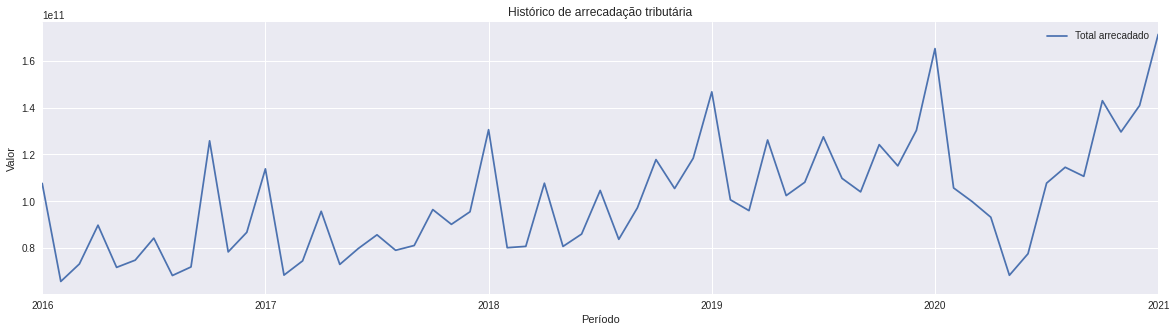

In [15]:
#Plotagem da série histórica
plt.figure(figsize=(20,5))
dfc['total'].plot(label = 'Total arrecadado')
plt.ylabel('Valor')
plt.xlabel('Período')
plt.title('Histórico de arrecadação tributária')
plt.legend();

In [16]:
# Agrupando arrecadação por ano. 1.356... e+12 = 1 trilhão e ... bilhões
dfc.groupby(dfc.index.year).sum()

,total
data,
2016,9.993687e+11
2017,1.034256e+12
2018,1.193638e+12
2019,1.391130e+12
2020,1.356489e+12
2021,1.711845e+11


In [17]:
#Resumo estatístico
dfc.describe()

,total
count,6.100000e+01
mean,1.007552e+11
std,2.426329e+10
min,6.586987e+10
25%,8.079364e+10
50%,9.725458e+10
75%,1.145344e+11
max,1.711845e+11


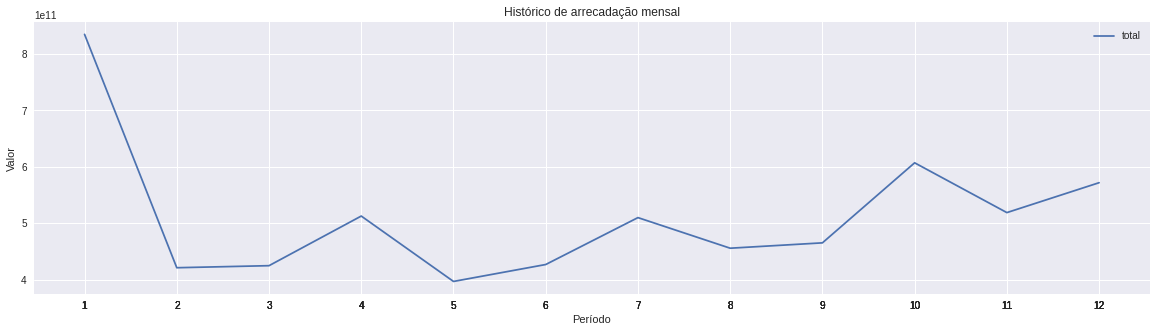

In [18]:
#Analisando tendência mensal
dfc.groupby(dfc.index.month).sum().plot(figsize=(20,5))
plt.ylabel('Valor')
plt.xlabel('Período')
plt.title('Histórico de arrecadação mensal')
plt.xticks(dfc.index.month)#mostrar todos os meses no eixo x
plt.legend();

In [19]:
#Agrupando total arrecadado por mês
dfc.groupby(dfc.index.month).sum()

,total
data,
1,8.350252e+11
2,4.211016e+11
3,4.247344e+11
4,5.127441e+11
5,3.967727e+11
6,4.267844e+11
7,5.099921e+11
8,4.557222e+11
9,4.652120e+11


<H3>SÉRIE HISTÓRICA DE VENDAS DIRETAS DE TÍTULOS DO TESOURO</H3>

In [20]:
dft

,Tipo Titulo,Vencimento do Titulo,Data Venda,PU,Quantidade,Valor
0,Tesouro IPCA+ com Juros Semestrais,15/05/2011,18/04/2007,"1614,899489","39,20","63304,05"
1,Tesouro Prefixado com Juros Semestrais,01/01/2017,18/04/2007,"962,583678","164,20","158056,23"
2,Tesouro IPCA+ com Juros Semestrais,15/08/2010,18/06/2007,"1661,335523","246,60","409685,33"
3,Tesouro Prefixado,01/01/2008,18/06/2007,"944,185764","430,60","406566,38"
4,Tesouro IPCA+ com Juros Semestrais,15/05/2009,18/06/2007,"1634,010294","6,80","11111,26"
...,...,...,...,...,...,...
64932,Tesouro IPCA+ com Juros Semestrais,15/08/2020,16/10/2014,"2566,814245","451,51","1158942,29"
64933,Tesouro Prefixado com Juros Semestrais,01/01/2025,16/10/2014,"960,414371","211,67","203290,90"
64934,Tesouro Selic,07/03/2017,16/10/2014,"6389,478706","827,23","5285568,46"
64935,Tesouro Prefixado,01/01/2017,16/10/2014,"780,780553","3611,82","2820038,81"


In [21]:
#identificado que não tem nenhum campo nulo e que data e valor precisam ser
#convertidos
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64937 entries, 0 to 64936
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Tipo Titulo           64937 non-null  object
 1   Vencimento do Titulo  64937 non-null  object
 2   Data Venda            64937 non-null  object
 3   PU                    64937 non-null  object
 4   Quantidade            64937 non-null  object
 5   Valor                 64937 non-null  object
dtypes: object(6)
memory usage: 3.0+ MB


In [22]:
#Alterando nomes das colunas para facilitar 
dft.columns = ['tipo', 'dtvecto', 'dtvenda', 'pu','qtde','valor']


In [23]:
#Alterando a vírgula por ponto para poder converter valor para numérico
v= {',': '.'}
dft = dft.replace(v, regex=True)


In [24]:
#Convertendo campo valor para numérico
dft["valor"]= pd.to_numeric(dft["valor"])


In [25]:
#Converte para datetime para poder gerar série
dft["dtvenda"]=pd.to_datetime(dft.dtvenda, format='%d/%m/%Y')

In [26]:
#Seta data como índice
dft.set_index('dtvenda', inplace=True)

In [27]:
#Agrupa valores por data
dft=pd.DataFrame(dft.groupby(by='dtvenda')['valor'].sum())
dft

,valor
dtvenda,
2002-01-04,5.677036e+04
2002-01-07,2.340568e+05
2002-01-08,2.266638e+05
2002-01-09,7.038599e+04
2002-01-10,8.449650e+04
...,...
2021-02-24,1.134048e+08
2021-02-25,1.175704e+08
2021-02-26,1.488114e+08


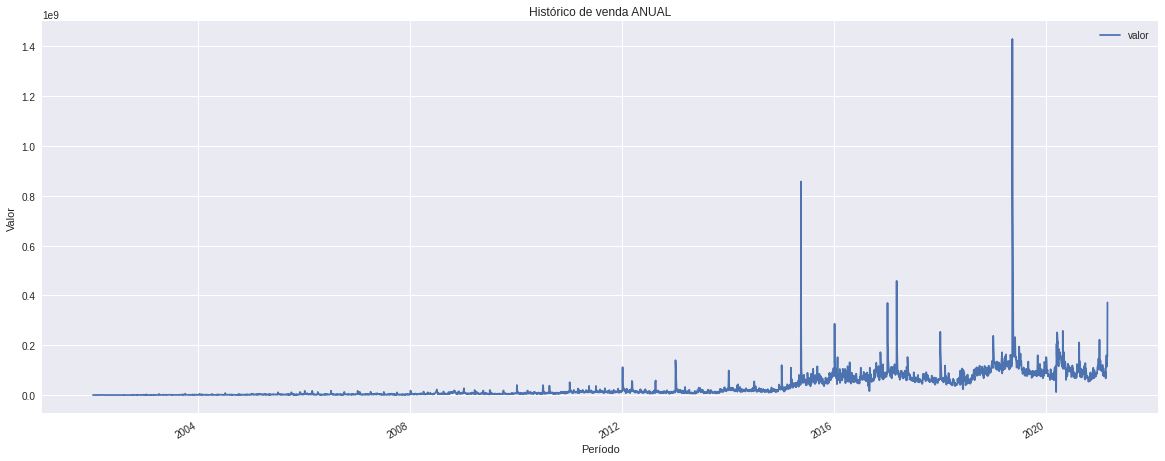

In [28]:
#Gráfico com vendas anuais
dft.plot(figsize=(20,8))
plt.ylabel('Valor')
plt.xlabel('Período')
plt.title('Histórico de venda ANUAL')
plt.legend()

In [29]:
#Agrupando vendas por ano
dft.groupby(dft.index.year).sum()

,valor
dtvenda,
2002,7.570973e+07
2003,2.493127e+08
2004,3.580181e+08
2005,6.570411e+08
2006,7.656330e+08
2007,7.676002e+08
2008,1.558320e+09
2009,1.562562e+09
2010,2.235620e+09


In [30]:
dft.describe()

,valor
count,4.730000e+03
mean,3.278072e+07
std,5.004819e+07
min,3.504960e+03
25%,2.702371e+06
50%,1.117701e+07
75%,5.942359e+07
max,1.428339e+09


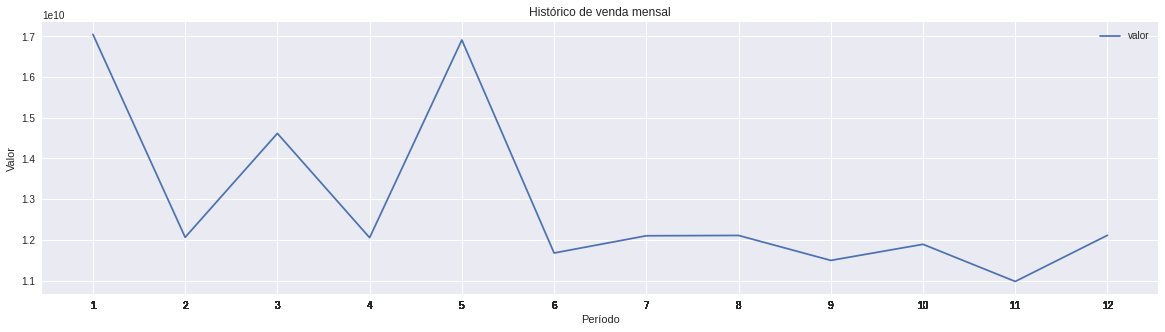

In [31]:
#Analisando tendência mensal
dft.groupby(dft.index.month).sum().plot(figsize=(20,5))
plt.ylabel('Valor')
plt.xlabel('Período')
plt.title('Histórico de venda mensal')
plt.xticks(dft.index.month)
plt.legend();

In [32]:
#Agrupando vendas por mês
dft.groupby(dft.index.month).sum()

,valor
dtvenda,
1,1.705067e+10
2,1.206261e+10
3,1.461656e+10
4,1.205318e+10
5,1.691264e+10
6,1.167605e+10
7,1.209978e+10
8,1.210778e+10
9,1.149448e+10



<H3>SÉRIE HISTÓRICA DO PIB</H3>

In [109]:
#Carrega a página e captura os dados
page = urllib.request.urlopen(pib)
soup = BeautifulSoup(page, 'html5lib')

In [110]:
#Carregando só a classe de interesse, conforme código html inspecionado
table = soup.find('table', class_='dxgvControl')


In [111]:
#Gerando a lista em colunas, buscando pelos códigos html tr e td
A=[]
B=[]

for row in table.findAll("tr"): #para tudo que estiver em <tr>
    cells = row.findAll('td') #variável para encontrar <td>
    if len(cells)==2: #número de colunas
        A.append(cells[0].find(text=True)) #iterando sobre cada linha
        B.append(cells[1].find(text=True))
        

In [112]:
#Salvando os dados capturados em um dataframe
dfpib = pd.DataFrame()
dfpib['Data']=A
dfpib['PIB']=B
dfpib

,Data,PIB
0,Data,None
1,PIB,None
2,1990.01,"0,2000"
3,1990.02,"0,4000"
4,1990.03,"0,8000"
...,...,...
371,2020.10,"652.937,9000"
372,2020.11,"664.466,5000"
373,2020.12,"656.583,4000"
374,2021.01,"636.631,3000"


In [113]:
#Conferindo tipo de dado e quantidade de registros
dfpib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    375 non-null    object
 1   PIB     374 non-null    object
dtypes: object(2)
memory usage: 6.0+ KB


In [115]:
#Identifica e sumariza valores nulos
dfpib.isnull().sum()

Data    1
PIB     2
dtype: int64

In [116]:
#Exclui linhas com missing values
dfpib.dropna(inplace=True)

In [117]:
#Alterando ponto para traço para poder converter para data
dfpib['Data'] = dfpib['Data'].str.replace('.','-')
dfpib

,Data,PIB
2,1990-01,"0,2000"
3,1990-02,"0,4000"
4,1990-03,"0,8000"
5,1990-04,"0,7000"
6,1990-05,"0,8000"
...,...,...
370,2020-09,"631.547,0000"
371,2020-10,"652.937,9000"
372,2020-11,"664.466,5000"
373,2020-12,"656.583,4000"


In [118]:
#Converte campo object para tipo data
dfpib['Data'] = pd.to_datetime(dfpib.Data)
dfpib

,Data,PIB
2,1990-01-01,"0,2000"
3,1990-02-01,"0,4000"
4,1990-03-01,"0,8000"
5,1990-04-01,"0,7000"
6,1990-05-01,"0,8000"
...,...,...
370,2020-09-01,"631.547,0000"
371,2020-10-01,"652.937,9000"
372,2020-11-01,"664.466,5000"
373,2020-12-01,"656.583,4000"


In [119]:
#Seta data como índice
dfpib.set_index('Data', inplace=True)

In [121]:
#Alterando a vírgula por ponto para poder converter valor para numérico
dfpib['PIB'] = dfpib['PIB'].str.replace('.','')
dfpib

,PIB
Data,
1990-01-01,"0,2000"
1990-02-01,"0,4000"
1990-03-01,"0,8000"
1990-04-01,"0,7000"
1990-05-01,"0,8000"
...,...
2020-09-01,"631547,0000"
2020-10-01,"652937,9000"
2020-11-01,"664466,5000"


In [122]:
#Trocando vírgula por ponto para poder converter 
dfpib['PIB'] = dfpib['PIB'].str.replace(',','.')

In [123]:
#Conversão para numérico
dfpib["PIB"] =pd.to_numeric(dfpib.PIB)
dfpib.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 1990-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PIB     373 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [124]:
#Multiplicando por 1 milhão pois conforme o site, a tabela estava assim reduzida
dfpib["PIB"] = dfpib["PIB"] * 1000000
dfpib

,PIB
Data,
1990-01-01,2.000000e+05
1990-02-01,4.000000e+05
1990-03-01,8.000000e+05
1990-04-01,7.000000e+05
1990-05-01,8.000000e+05
...,...
2020-09-01,6.315470e+11
2020-10-01,6.529379e+11
2020-11-01,6.644665e+11


In [125]:
#Reduzir o período para os últimos 20 anos
dfpib = dfpib.loc['2001-01-01':'2020-12-01']
dfpib

,PIB
Data,
2001-01-01,1.025307e+11
2001-02-01,1.016353e+11
2001-03-01,1.083038e+11
2001-04-01,1.075720e+11
2001-05-01,1.112022e+11
...,...
2020-08-01,6.298884e+11
2020-09-01,6.315470e+11
2020-10-01,6.529379e+11


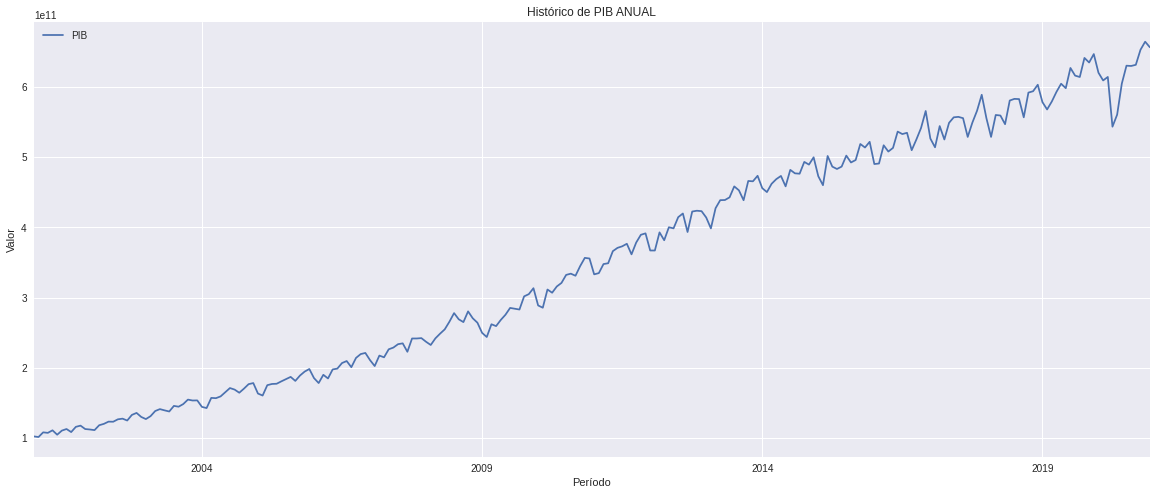

In [48]:
#Gráfico com evoluçaõ do PIB anual
dfpib.plot(figsize=(20,8))
plt.ylabel('Valor')
plt.xlabel('Período')
plt.title('Histórico de PIB ANUAL')
plt.legend();

In [49]:
#Seleciona ano de 2020
dfpib2020 = dfpib.loc['2020-01-01':'2020-12-01']

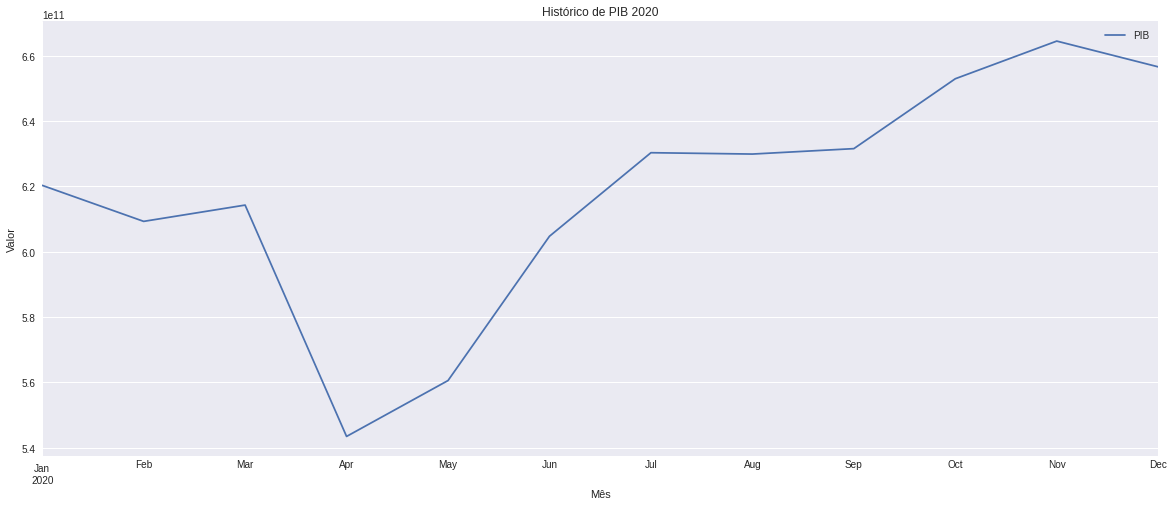

In [50]:
#Gráfico com evoluçaõ do PIB anual 2020
dfpib2020.plot(figsize=(20,8))
plt.ylabel('Valor')
plt.xlabel('Mês')
plt.title('Histórico de PIB 2020')
plt.grid(True)
plt.legend();

In [51]:
#Valor PIB ano a ano
dfpib.groupby(dfpib.index.year).sum()

,PIB
Data,
2001,1.315756e+12
2002,1.488787e+12
2003,1.717950e+12
2004,1.957751e+12
2005,2.170585e+12
2006,2.409450e+12
2007,2.720263e+12
2008,3.109803e+12
2009,3.333039e+12


In [52]:
#Resumo estatístico da série
dfpib.describe()

,PIB
count,2.400000e+02
mean,3.525886e+11
std,1.701671e+11
min,1.016353e+11
25%,1.886989e+11
50%,3.464217e+11
75%,5.085378e+11
max,6.644665e+11


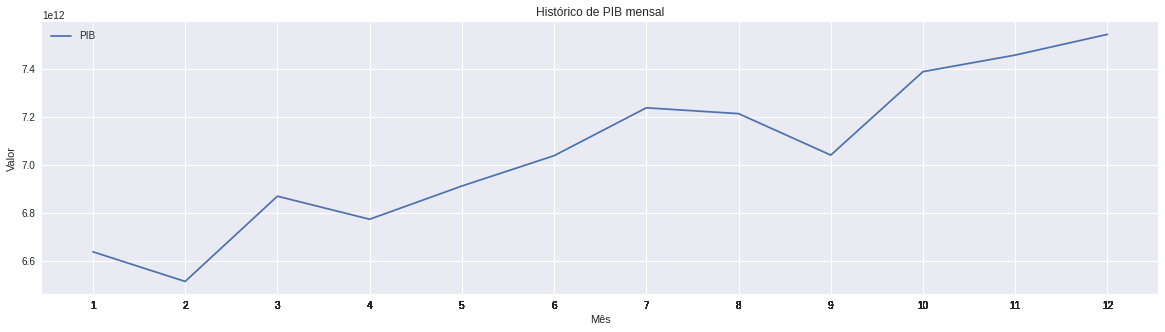

In [53]:
#Analisando tendência mensal
dfpib.groupby(dfpib.index.month).sum().plot(figsize=(20,5))
plt.ylabel('Valor')
plt.xlabel('Mês')
plt.title('Histórico de PIB mensal')
plt.xticks(dfpib.index.month)
plt.legend();

In [54]:
#Agrupando vendas por mês
dfpib.groupby(dfpib.index.month).sum()

,PIB
Data,
1,6.637738e+12
2,6.514292e+12
3,6.869100e+12
4,6.773197e+12
5,6.911541e+12
6,7.037814e+12
7,7.237122e+12
8,7.212888e+12
9,7.040282e+12


<H3> Análise conjunta das 3 séries</h3>


In [55]:
#Agrupa a série do tesouro por mês/ano para poder comparar com a arrecadação
dft2= pd.DataFrame(dft.resample('M').valor.sum())


In [56]:
#Seleciona mesmo período da arrecadação para comparação
dftc = dft2.loc['2016-01-01':'2020-12-31']

#reseta o índice para dtvenda voltar a ser coluna
dftc.reset_index(inplace=True) 

# converte data para que todos os meses tenham dia = 1
dftc['dtvenda'] = pd.to_datetime(dftc["dtvenda"].dt.strftime('%Y-%m')) 

#Seta dtvenda como índice
dftc.set_index('dtvenda', inplace=True) 


In [57]:
#Seleciona mesmo período da arrecadação para comparação
dfpib = dfpib.loc['2016-01-01':'2020-12-31']

In [58]:
#Junta a série da arrecadação com vendas do tesouro e pib
dftc = pd.concat([dftc,dfc,dfpib], axis=1) 

#altera nome das colunas
dftc.columns = ['TotalTesouro', 'TotalArrecadacao', 'TotalPib'] 

In [59]:
dftc.head()

,TotalTesouro,TotalArrecadacao,TotalPib
2016-01-01,1.847655e+09,1.076563e+11,4.902840e+11
2016-02-01,1.377834e+09,6.586987e+10,4.910117e+11
2016-03-01,1.750504e+09,7.332966e+10,5.169859e+11
2016-04-01,1.388322e+09,8.984688e+10,5.080587e+11
2016-05-01,1.433487e+09,7.186617e+10,5.132675e+11


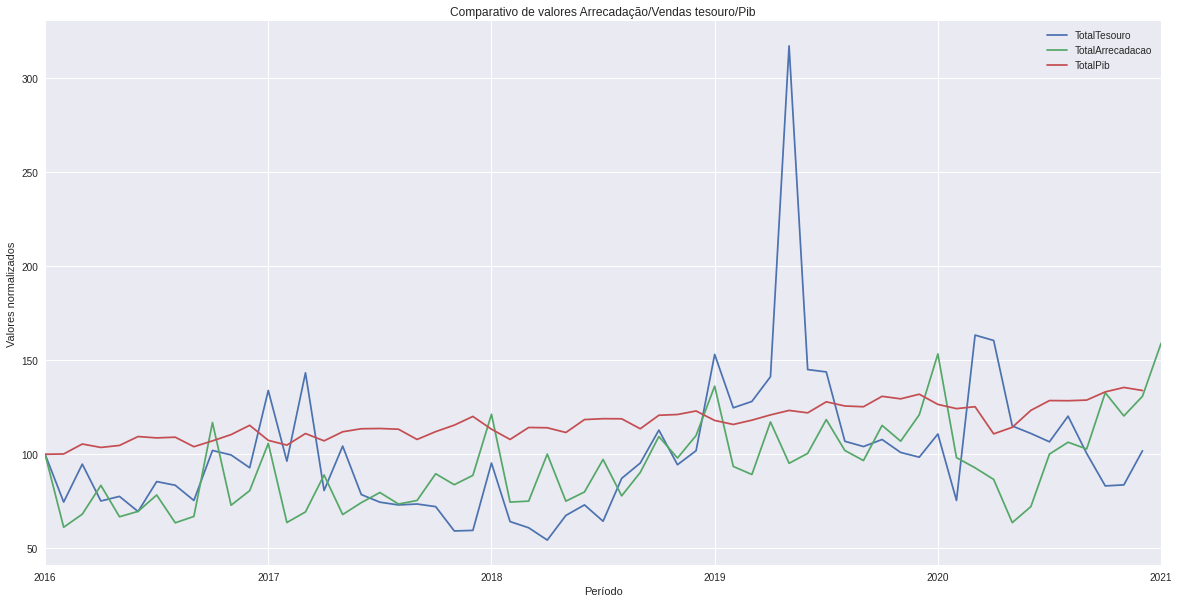

In [60]:
#Gráfico normalizado das séries   
(dftc/dftc.iloc[0]*100).plot(figsize=(20,10))
plt.ylabel('Valores normalizados')
plt.xlabel('Período')
plt.title('Comparativo de valores Arrecadação/Vendas tesouro/Pib')
plt.show()

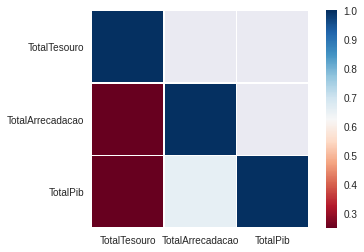

In [61]:
#Função para criação do mapa de correlação das séries
def plot_corr(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True
    sns.heatmap(corr, mask=mask, cmap='RdBu', square=True, linewidths=.5)
    
# Cálculo da correlação
corr = dftc.corr() 
plot_corr(corr)

In [62]:
dftc

,TotalTesouro,TotalArrecadacao,TotalPib
2016-01-01,1.847655e+09,1.076563e+11,4.902840e+11
2016-02-01,1.377834e+09,6.586987e+10,4.910117e+11
2016-03-01,1.750504e+09,7.332966e+10,5.169859e+11
2016-04-01,1.388322e+09,8.984688e+10,5.080587e+11
2016-05-01,1.433487e+09,7.186617e+10,5.132675e+11
...,...,...,...
2020-09-01,1.855643e+09,1.106749e+11,6.315470e+11
2020-10-01,1.536472e+09,1.429072e+11,6.529379e+11
2020-11-01,1.546731e+09,1.295847e+11,6.644665e+11
2020-12-01,1.881859e+09,1.408611e+11,6.565834e+11


## Modelos preditivos para série temporal do tesouro direto

In [63]:
#Separando dados de treino e teste
dft_treino = dft.loc['2015-01-01':'2019-12-31']
dft_teste = dft.loc['2020-01-01':'2020-12-31']

## Modelo auto-arima

In [64]:
#Carregamento dos dados para treino e teste
dft_treino_arima = dft_treino
dft_teste_arima = dft_teste

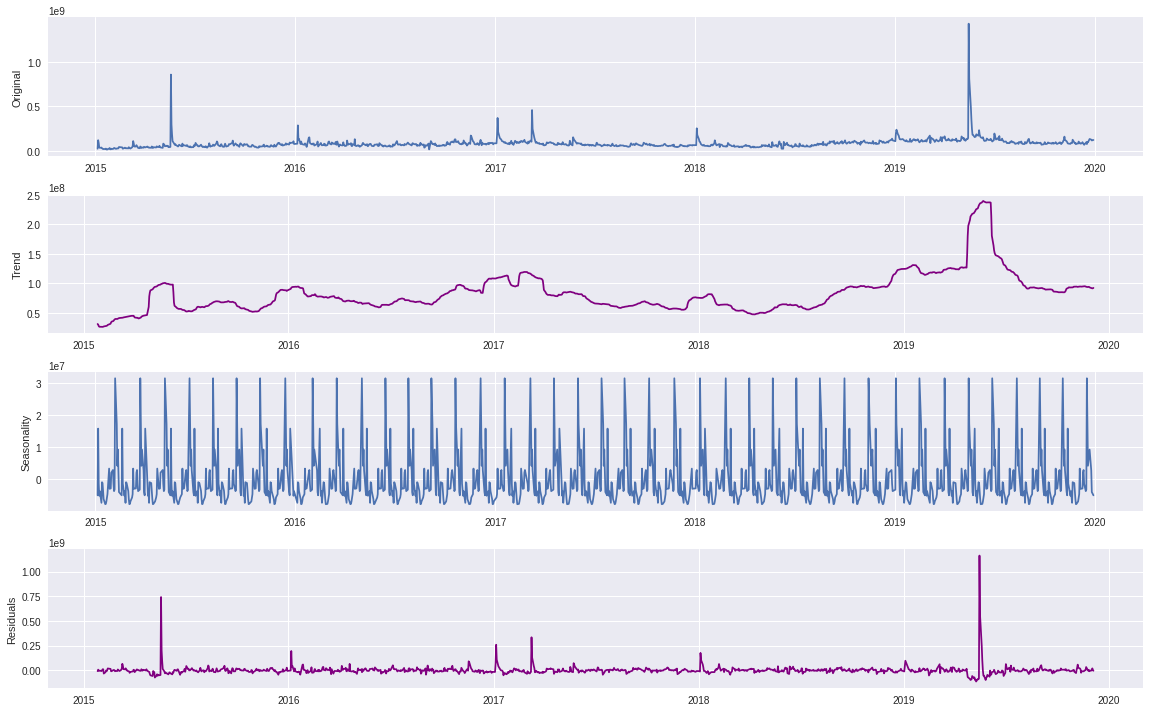

In [65]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dft_treino_arima, model='', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(16,10))
plt.subplot(411)
plt.plot(dft_treino_arima)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend,color='purple')
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual, color='purple')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

**Dickey-Fuller teste**: esse é um dos testes estatísticos para verificar Estacionaridade. Aqui, a hipótese nula é que o TS é não-estacionária. Os resultados do teste são compostos por uma estatística de teste e alguns valores críticos para os níveis de confiança da diferença. Se o ‘teste estatístico’ é menor do que o “valor crítico”, podemos rejeitar a hipótese nula e dizer que a série é estacionária

In [66]:
#Função para verificar a estacionariedade 
#Valor p mostra se série é estacionária ou não, abaixo de 0.05 é estacionária.
#P é menor que 0.05 e O valor de teste é menor que todos os vlres críticos,
#portanto é estacionária
def adf_test(y):
    print('Resultado do Teste Dickey-Fuller:')
    dftest = adfuller(y, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Teste','Valor p', 'Nº de lags',
                                             'Nº de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico ({})'.format(key)] = value
    print(dfoutput)

adf_test(dft_treino_arima)

Resultado do Teste Dickey-Fuller:
Teste                 -6.586118e+00
Valor p                7.307584e-09
Nº de lags             9.000000e+00
Nº de observações      1.221000e+03
Valor Crítico (1%)    -3.435717e+00
Valor Crítico (5%)    -2.863910e+00
Valor Crítico (10%)   -2.568032e+00
dtype: float64


AxesSubplot(0.125,0.536818;0.775x0.343182)
AxesSubplot(0.125,0.125;0.775x0.343182)


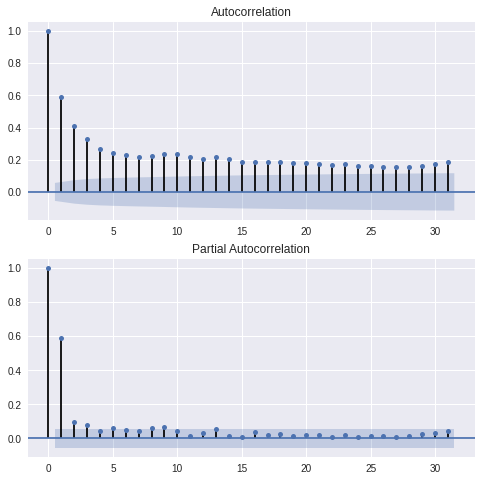

In [67]:
#Plotagem dos gráficos ACF e PACF
#Autocorrelação é a relação de um lag(período) com o anterior, quanto mais perto 
#de 1 maior é a correlação. Varia de 1 a -1
#No caso, p lag 0 deu 1 porque a comparação é com ele mesmo. A área mais perto
# de zero indica menor correlação. 
#A área azul no gráfico representa valores não confiáveis para a análise, 
#Na autocorrelação um período influencia no anterior, já na parcial, ela sempre
#é feita em relação ao período t(0) 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(dft_treino_arima, ax = ax1)
plot_pacf(dft_treino_arima, ax = ax2)

print (ax1)
print (ax2)

plt.show()


In [68]:
#Definição do modelo
#p representa número de lags(períodos), q é a ordem do modelo 
modelo = pm.auto_arima(dft_treino_arima['valor'], start_p=1, start_q=1,
                      max_p=3, max_q=3, # Máximo 'p' e 'q'
                      m=12,              # Frequência da série
                      d=0,           # d do arima, diferenciação
                      stationary = True, #Estacionaridade
                      seasonal=True, #Sazonalidade
                      start_P=0, 
                      D=0, 
                      trace=True, #Se TRUE, a lista de modelos será reportada.
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False) #Se TRUE, fará a seleção gradual (mais
                      # rápido). Caso contrário, ele pesquisará todos os modelos.

#Treinamento do modelo
modelo.fit(dft_treino_arima)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=47672.191, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=47632.071, Time=0.35 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=47618.472, Time=1.39 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=47655.365, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=47620.337, Time=4.32 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=47657.162, Time=2.42 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=47616.176, Time=4.19 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=11.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=47332.189, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=47320.691, Time=0.52 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=47316.288, Time=1.56 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=47320.799, Time=0.73 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=47320.444, Time=1.75 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=47316.458, Time=

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [69]:
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1231
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -23556.255
Date:                Fri, 12 Mar 2021   AIC                          47126.509
Time:                        19:04:41   BIC                          47162.318
Sample:                             0   HQIC                         47139.981
                               - 1231                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.277e+07   1.63e-08    1.4e+15      0.000    2.28e+07    2.28e+07
ar.L1         -0.1011      0.330     -0.307      0.759      -0.747       0.545
ar.L2          0.8284      0.328      2.527      0.0

In [70]:
#Faz a predição para 12 meses
forecast_arima = modelo.predict(n_periods=len(dft_teste_arima['valor']))
forecast_arima = pd.DataFrame(forecast_arima, index = dft_teste_arima.index,
                              columns=['Prediction'])
conf_int = modelo.predict(len(dft_teste_arima['valor']), return_conf_int=True, 
                          alpha = 0.05) #Pega o intervalo de confiança

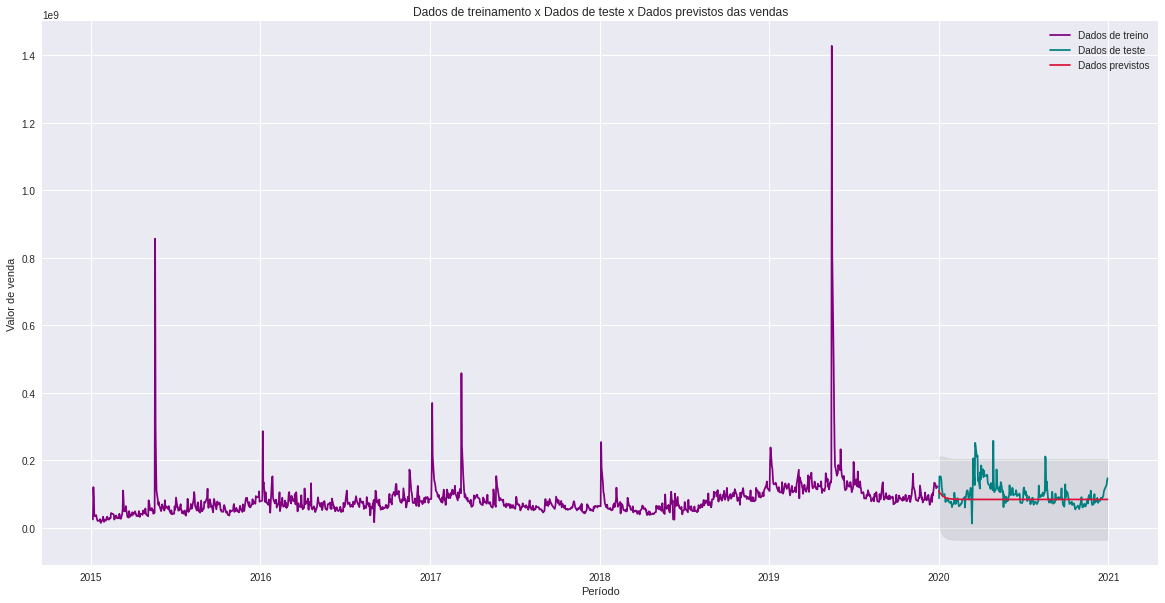

In [71]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(20,10))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das vendas')
plt.plot(dft_treino_arima['valor'], color='purple', label ='Dados de treino')
plt.plot(dft_teste_arima['valor'], color = 'teal', label = 'Dados de teste')
plt.fill_between(dft_teste_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color ='crimson', label ='Dados previstos')
plt.xlabel('Período')
plt.ylabel('Valor de venda')
plt.legend()
plt.show()

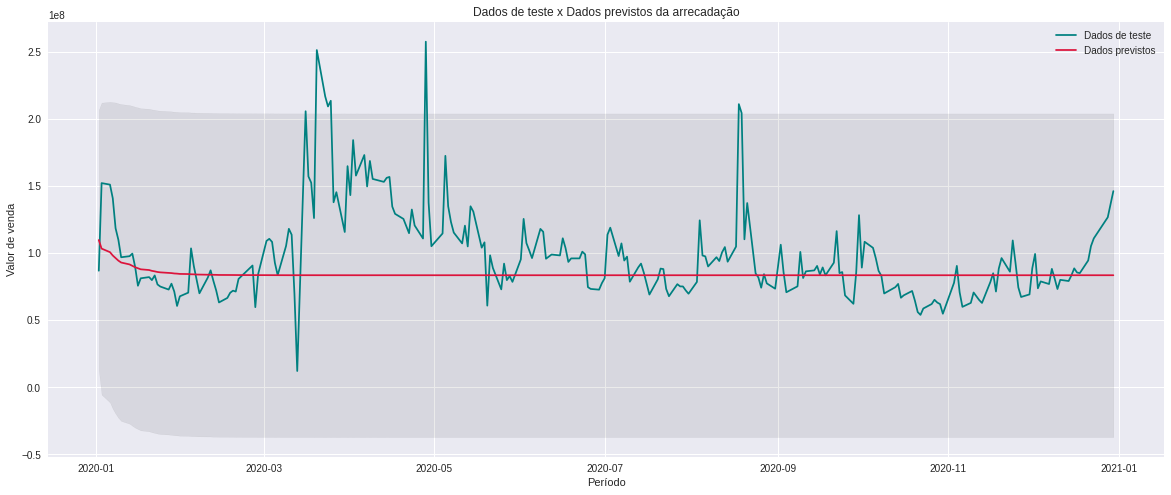

In [72]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(20,8))
plt.title('Dados de teste x Dados previstos da arrecadação')
plt.plot(dft_teste_arima['valor'], color = 'teal', label = 'Dados de teste')
plt.fill_between(dft_teste_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color ='crimson', label ='Dados previstos')
plt.xlabel('Período')
plt.ylabel('Valor de venda')
plt.legend()
plt.show()

In [73]:
#Função para cálculo do mape-erro médio absoluto percentual
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [74]:
#Cálculo do erro
#MSE= erro quadrático médio média do erro das previsões ao quadrado, qto >
#pior o modelo
#RMSE = raiz do erro quadrático médio
#MAE = Erro absoluto médio, média das distâncias entre previsão e o real, não 
#pune tanto outliers como os dois anteriores
#MAPE = média do Percentual de erro médio absoluto(módulo dos negativos), 
#quanto menor melhor
mse = mean_squared_error(dft_teste_arima['valor'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dft_teste_arima['valor'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dft_teste_arima['valor'],
                                    forecast_arima['Prediction']))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(dft_teste_arima['valor'], 
                                      forecast_arima['Prediction'])
print('MAPE: '+str(mape))

MSE: 1402529647266108.2
MAE: 24121608.25647384
RMSE: 37450362.44505663
MAPE: 22.826109655887613


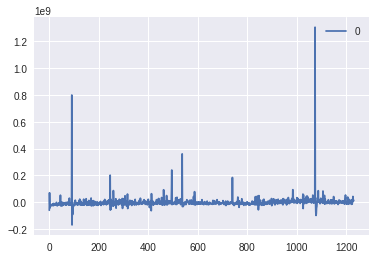

In [75]:
#Plotagem dos resíduos(diferença entre)
residuals = pd.DataFrame(modelo.resid())
residuals.plot()

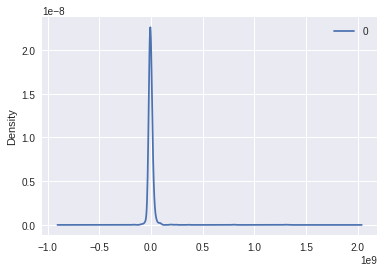

                  0
count  1.231000e+03
mean  -2.021382e+05
std    4.949383e+07
min   -1.686978e+08
25%   -1.231371e+07
50%   -5.191278e+06
75%    4.586422e+06
max    1.304729e+09


In [76]:
#Plotagem da densidade dos resíduos(erros residuais)
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

<h3>Modelo preditivo com RNN com arquitetura LSTM (Long Short Term Memory)</h3>

In [77]:
#Carregamento dos dados
dft_treino_lstm = dft_treino
dft_teste_lstm = dft_teste

In [78]:
#Normalização dos dados, entre 0 e 1

train_lstm = dft_treino_lstm.iloc[:,0:1].values# seleciona o valor

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 


In [79]:
#Criação de uma estrutura de dados com 60 timesteps e 1 saída 
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) 
    y_train_lstm.append(train_scaled_lstm[i, 0]) 
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [80]:
#Reshaping o dataset de treinamento 
#Sendo o segundo parâmetro como: 
#x_train_lstm.shape[0] = batch_size, que é o vlr de vendas do período de treino
#x_train_lstm.shape[1] = time_step, que é o vlr de vendas anteriores
       
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], 
                                         x_train_lstm.shape[1], 1))


In [81]:
#Criação da LSTM utilizando a biblioteca Keras

# Inicialização da RNN
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout. Units é qtde de neurônio
model_rnn.add((LSTM(units = 128, return_sequences = True, 
                    input_shape = (x_train_lstm.shape[1], 1))))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 128))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída
model_rnn.add(Dense(1, activation='linear'))


# Compila a RNN, utilizando o otimizador 'Adam', que ajusta hiperparâmetros
model_rnn.compile(optimizer = 'adam', loss = 'mape', metrics=['mae','mse'])

# Faz o treinamento da RNN utilizando o dataset de treinamento. Épocas são
# quantas vezes vai iterar, teste com até 500 épocas e batch=256
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 64) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
19/19 [==============================] - 8s 230ms/step - loss: 52.1806 - mae: 0.0264 - mse: 0.0027
Epoch 2/100
19/19 [==============================] - 4s 226ms/step - loss: 26.4370 - mae: 0.0135 - mse: 8.2100e-04
Epoch 3/100
19/19 [==============================] - 4s 229ms/step - loss: 26.9230 - mae: 0.0139 - mse: 0.0016
Epoch 4/100
19/19 [==============================] - 4s 227ms/step - loss: 23.4207 - mae: 0.0127 - mse: 0.0012
Epoch 5/100
19/19 [==============================] - 4s 228ms/step - loss: 25.2768 - mae: 0.0151 - mse: 0.0023
Epoch 6/100
19/19 [==============================] - 4s 227ms/step - loss: 32.0827 - mae: 0.0143 - mse: 0.0012
Epoch 7/100
19/19 [==============================] - 4s 229ms/step - loss: 26.0174 - mae: 0.0152 - mse: 0.0026
Epoch 8/100
19/19 [==============================] - 4s 228ms/step - loss: 24.9297 - mae: 0.0132 - mse: 0.0013
Epoch 9/100
19/19 [==============================] - 4s 224ms/step - loss: 29.1698 - mae: 0.0128 - mse: 0.00

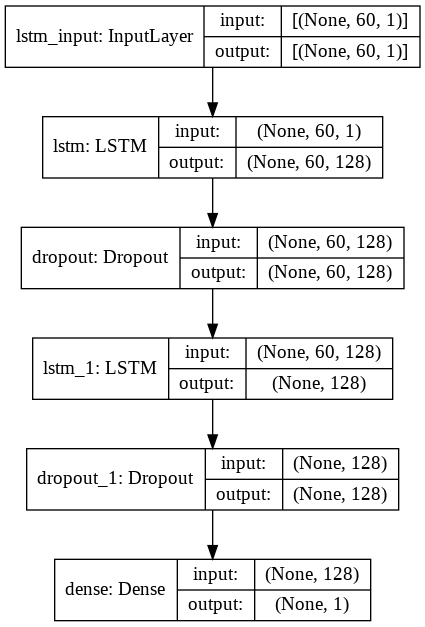

In [82]:
#Visualização do modelo tive que instalar pydot e graphviz
plot_model(model_rnn, show_shapes=True) 

In [83]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = dft_teste_lstm.iloc[:,0:1].values 

In [84]:
# Concatena os dados de treinamento e teste
combine = pd.concat((dft_treino_lstm['valor'], dft_teste_lstm['valor']), axis=0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(dft_teste_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [85]:
# Predição utilizando os dados de teste
x_test_lstm = []

for i in range(timesteps, dft_teste_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])

x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], 
                                       x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

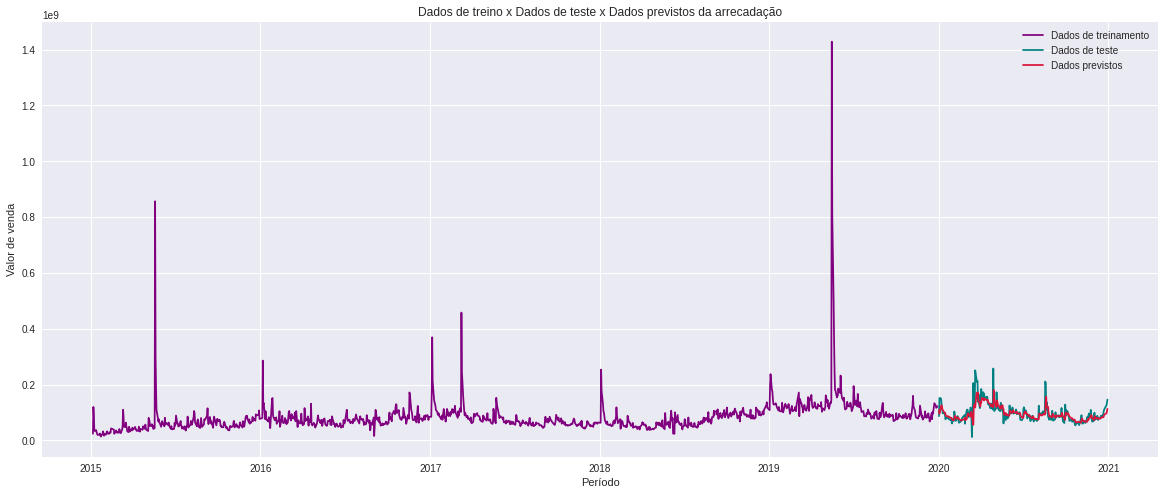

In [86]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(20,8))
plt.plot(dft_treino_lstm.index, dft_treino_lstm, color='purple', 
         label = 'Dados de treinamento')
plt.plot(dft_teste_lstm.index, test_lstm, color = 'teal', 
         label = 'Dados de teste')
plt.plot(dft_teste_lstm.index, predictions_lstm, color = 'crimson', 
         label = 'Dados previstos')
plt.title('Dados de treino x Dados de teste x Dados previstos da arrecadação')
plt.xlabel('Período')
plt.ylabel('Valor de venda')
plt.legend()
plt.show()

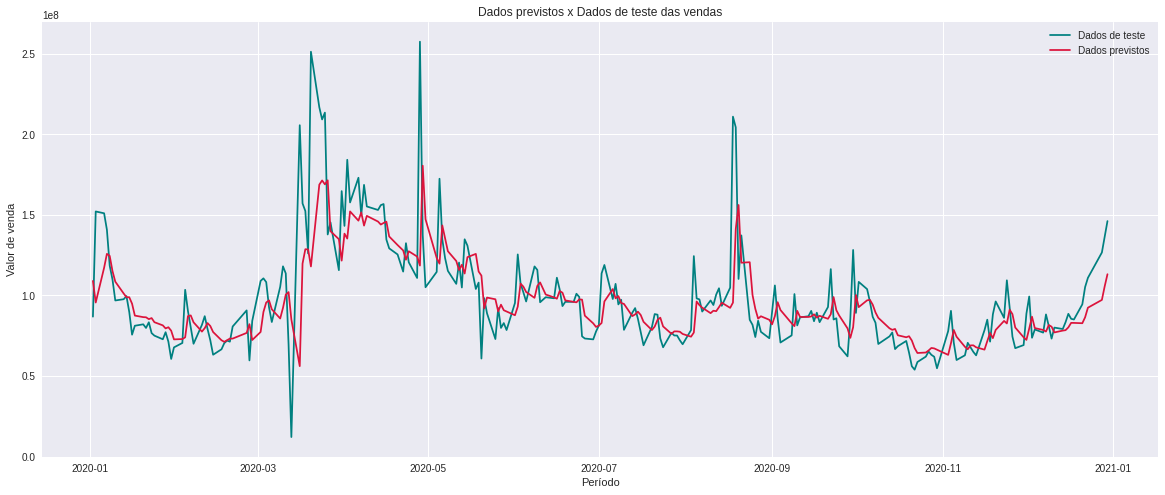

In [87]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(20,8))
plt.plot(dft_teste_lstm.index, test_lstm, color = 'teal', 
         label = 'Dados de teste')
plt.plot(dft_teste_lstm.index, predictions_lstm, color = 'crimson', 
         label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste das vendas')
plt.xlabel('Período')
plt.ylabel('Valor de venda')
plt.legend()
plt.show()

In [88]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(test_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(test_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(test_lstm,predictions_lstm)))
print('MAPE ', mean_absolute_percentage_error(test_lstm, predictions_lstm))


MAE:  14670043.122088352
MSE:  606910686731360.4
RMSE:  24635557.365957044
MAPE  15.604070183006941


### FACEBOOK 

In [89]:
#Carregamento dos dados de treinamento e teste
dft_treino_prophet = dft_treino
dft_teste_prophet = dft_teste

In [90]:
#Renomeia as colunas 'total' para 'y' e 'data' para 'ds' do conjunto de treino
dft_treino_prophet = pd.DataFrame({"ds": dft_treino_prophet.index, 
                                   "y": dft_treino_prophet.valor})
dft_treino_prophet.reset_index(drop = True, inplace = True)
dft_treino_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1231 non-null   datetime64[ns]
 1   y       1231 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.4 KB


In [91]:
#Renomeia as colunas 'valor' para 'y' e 'data' para 'ds' do conjunto de treino
dft_teste_prophet = pd.DataFrame({"ds_test": dft_teste_prophet.index,
                                  "y_test": dft_teste_prophet.valor})
dft_teste_prophet.reset_index(drop = True, inplace = True)
dft_teste_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds_test  249 non-null    datetime64[ns]
 1   y_test   249 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [92]:
#Utiliza a biblioteca Prophet para fazer a previsão
#parâmetro changepoint_prior_scale ajusta a tendência
#parâmetro seasonality_prior_scale ajusta sazonaliadde
#interval_width pode ser de 85% ou 95%
from fbprophet import Prophet

prophet_model = Prophet(changepoint_prior_scale=0.15, interval_width=0.95, 
                        seasonality_prior_scale=0.01, 
                        daily_seasonality=True, seasonality_mode='multiplicative')
prophet_model.fit(dft_treino_prophet)


Text(65.0, 0.5, 'Valor')

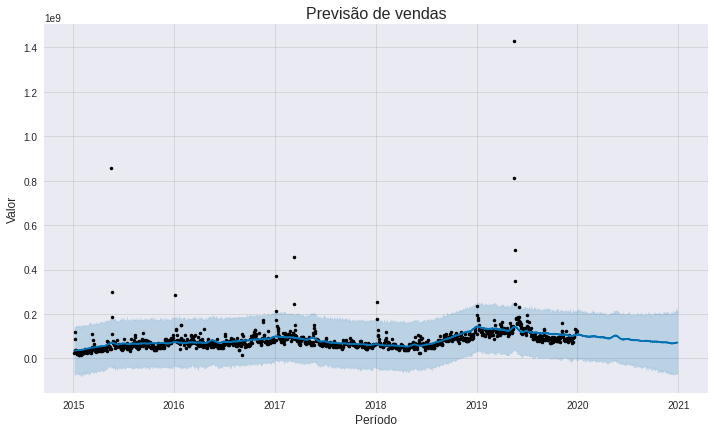

In [93]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=365, freq='D')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de vendas", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Valor", fontsize=12)

In [94]:
#yhat é o valor predito, yhat_lower e upper são os valores para intervalo de
#confiança
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1591,2020-12-25,7.046754e+07,-6.806012e+07,2.136153e+08
1592,2020-12-26,7.109453e+07,-6.743444e+07,2.075839e+08
1593,2020-12-27,7.125870e+07,-6.553184e+07,2.199335e+08
1594,2020-12-28,7.072977e+07,-6.697058e+07,2.180606e+08
1595,2020-12-29,7.206778e+07,-6.975362e+07,2.147340e+08


In [95]:
#Seleciona os dados previstos apenas para o período de teste
train_end_date = "2019-12-31"
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > train_end_date]

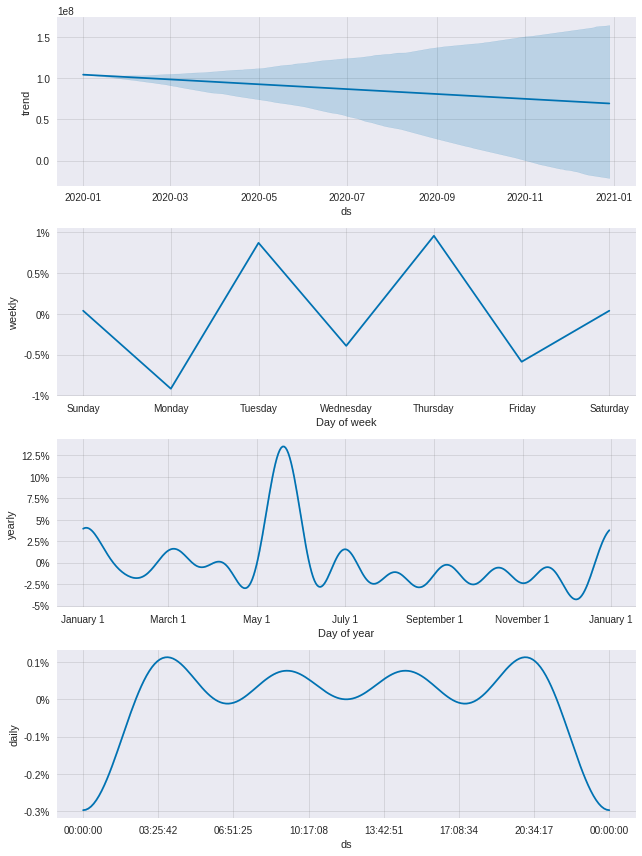

In [96]:
#Plotagem dos componententes da previsão
fig = prophet_model.plot_components(prophet_forecast)

In [97]:
#Exclusão dos fins de semana nos dados previstos
prophet_forecast = prophet_forecast[prophet_forecast['ds'].dt.dayofweek < 5]

#Exclusão dos feriados nos dados previstos
holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(['2020-01-01','2020-02-24','2020-02-25','2020-04-10',
                          '2020-04-21','2020-05-01','2020-06-11','2020-09-07',
                          '2020-10-12','2020-11-02','2020-11-15','2020-12-25',
                          '2020-12-31']),
})

prophet_forecast = prophet_forecast[~prophet_forecast['ds'].isin(holidays['ds'])]
prophet_forecast = prophet_forecast.dropna()


In [98]:
#Converte para datatetime
prophet_forecast['ds']= pd.to_datetime(prophet_forecast['ds'])
dft_teste_prophet['ds_test']= pd.to_datetime(dft_teste_prophet['ds_test'])
dft_treino_prophet['ds']= pd.to_datetime(dft_treino_prophet['ds'])

In [99]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dft_teste_prophet.set_index(dft_teste_prophet['ds_test'], inplace=True) 
dft_treino_prophet.set_index(dft_treino_prophet['ds'], inplace=True) 

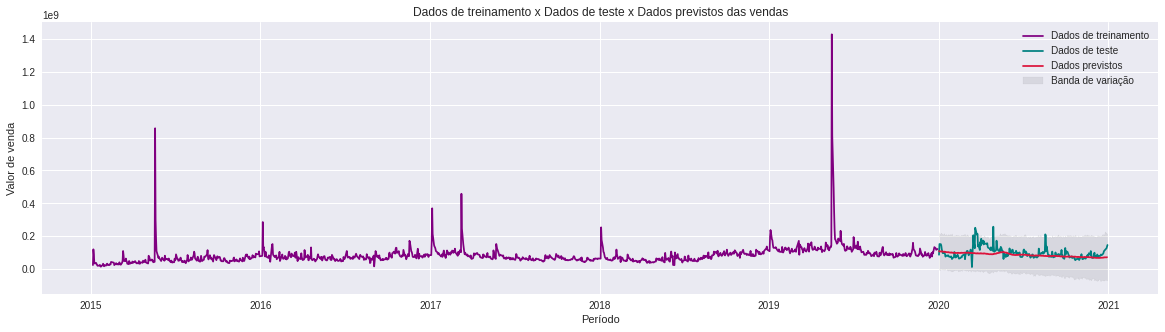

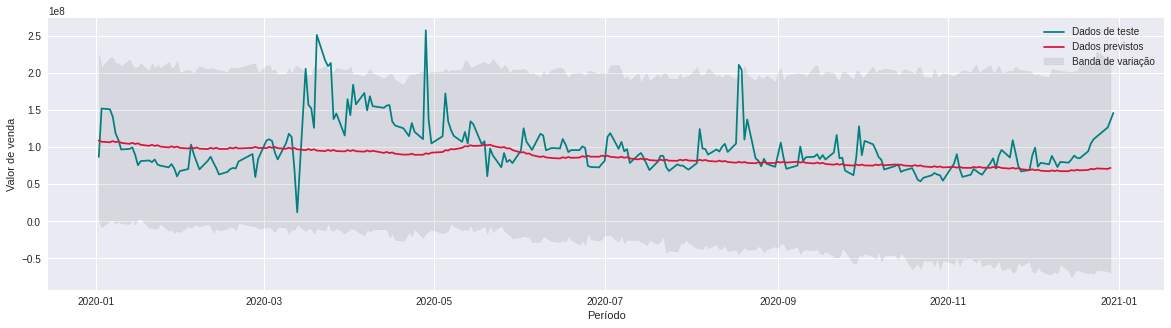

In [100]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dft_treino_prophet.shape[0]
plt.figure(figsize=(20,5))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das vendas')
plt.plot(dft_treino_prophet['y'], 'purple', label='Dados de treinamento')
plt.plot(dft_teste_prophet['y_test'], color = 'teal', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'crimson', 
         label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:],prophet_forecast['yhat_lower'][-n:],
                 prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, 
                 label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Valor de venda")
plt.legend()

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(20,5))
plt.plot(dft_teste_prophet['y_test'], color = 'teal', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'crimson', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:],
                 prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, 
                 label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Valor de venda")
plt.legend()

plt.show()

In [101]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dft_teste_prophet['y_test'],
                                   prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dft_teste_prophet['y_test'],
                                  prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dft_teste_prophet['y_test'],
                                           prophet_forecast['yhat'])))
print('MAPE:', mean_absolute_percentage_error(dft_teste_prophet['y_test'], 
                                              prophet_forecast['yhat']))

MAE:  23952364.510146044
MSE:  1255983430959238.2
RMSE:  35439856.531301565
MAPE: 23.96043691469447


<h3>Modelo LSTM treinado utilizado nos dados futuros</h3>
Esse foi o modelo escolhido por ter o menor MAPE

In [102]:
#Testa modelo para o futuro
futuro_teste_dft_lstm =  dft.loc['2021-01-01':'2021-02-28']

In [103]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento 
# anteriores não estão no conjunto de teste
combine = pd.concat((dft_teste_lstm[-timesteps:]['valor'], 
                     futuro_teste_dft_lstm['valor']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
teste_inputs = combine[len(combine) - len(futuro_teste_dft_lstm['valor']) -
                       timesteps:].values
teste_inputs = teste_inputs.reshape(-1,1)

# Normalização dos dados
teste_inputs = scaler.transform(teste_inputs)

In [104]:
# Predição utilizando os dados de teste futuro
x_test_lstm = []
for i in range(timesteps, futuro_teste_dft_lstm.shape[0]+timesteps):
    x_test_lstm.append(teste_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], 
                                       x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

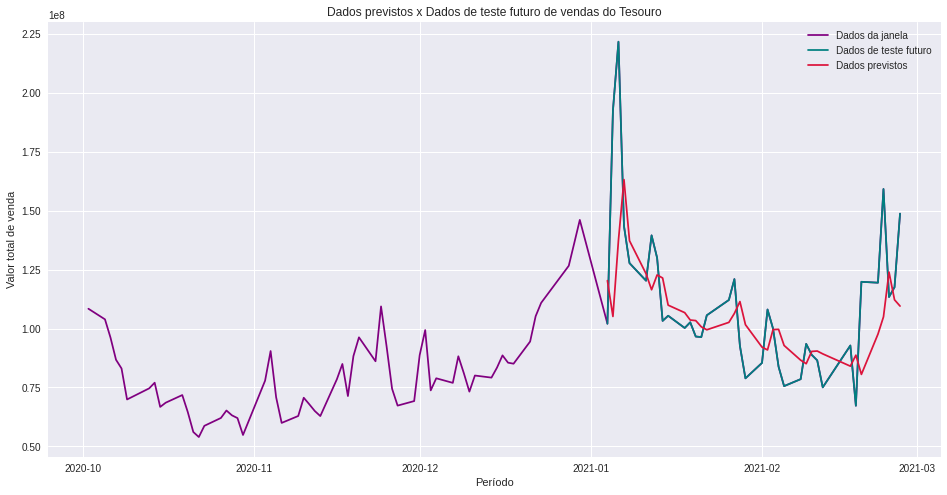

In [105]:
#Plotagem dos dados da janela, dados de teste futuro e dados previstos
plt.figure(figsize=(16,8))
plt.plot(combine.index, combine.values, color = 'purple', 
         label = 'Dados da janela')
plt.plot(futuro_teste_dft_lstm.index, futuro_teste_dft_lstm, color = 'teal',
         label = 'Dados de teste futuro')
plt.plot(futuro_teste_dft_lstm.index, predictions_lstm, color = 'crimson',
         label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste futuro de vendas do Tesouro')
plt.xlabel('Período')
plt.ylabel('Valor total de venda')
plt.legend()
plt.show()

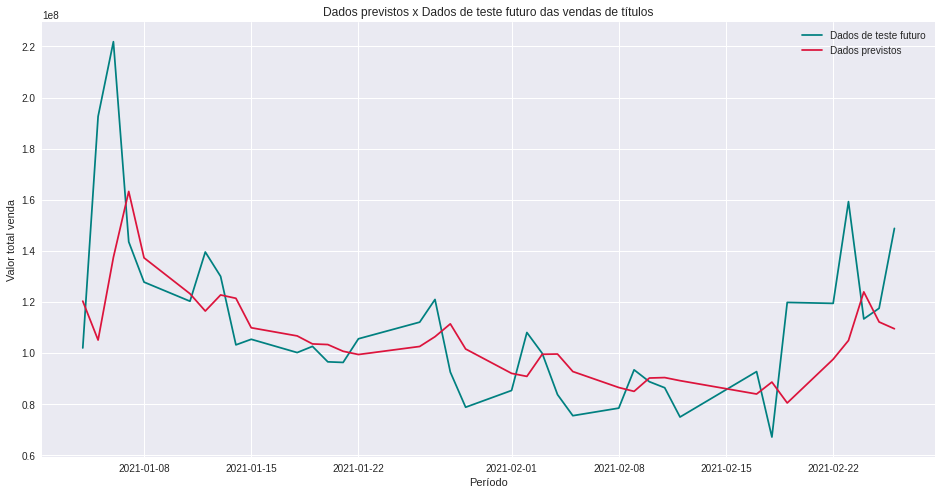

In [106]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(futuro_teste_dft_lstm.index, futuro_teste_dft_lstm, color = 'teal', 
         label = 'Dados de teste futuro')
plt.plot(futuro_teste_dft_lstm.index, predictions_lstm, color = 'crimson', 
         label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste futuro das vendas de títulos')
plt.xlabel('Período')
plt.ylabel('Valor total venda')
plt.legend()
plt.show()

In [107]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(futuro_teste_dft_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(futuro_teste_dft_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(futuro_teste_dft_lstm,
                                           predictions_lstm)))
print('MAPE', mean_absolute_percentage_error(futuro_teste_dft_lstm, 
                                             predictions_lstm))

MAE:  17841807.434054047
MSE:  710213449617971.2
RMSE:  26649830.19867052
MAPE 14.613295210926628


**FIM**